In [1]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

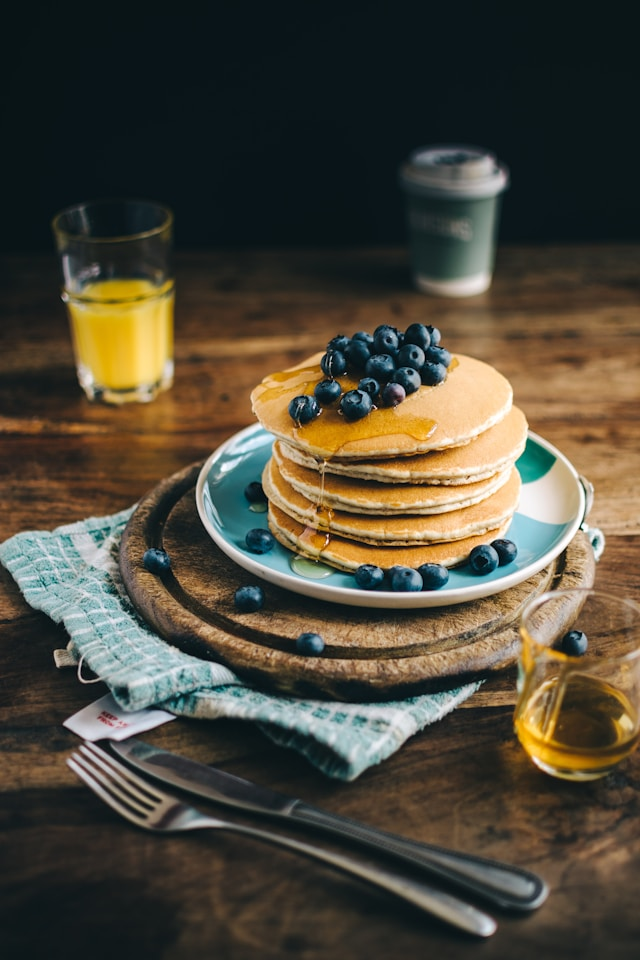

In [2]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)
image

In [3]:
image.height, image.width

(960, 640)

In [4]:
prompts = ["table", "pancakes", "blueberries", "orange juice"]

In [44]:
import torch
from torch.functional import F

inputs = processor(
    text=prompts, images=[image] * len(prompts), padding=True, return_tensors="pt"
)
# predict
with torch.no_grad():
    outputs = model.forward(**inputs)
preds = (
    F.interpolate(
        outputs.logits.unsqueeze(1),
        size=(image.height, image.width),
        mode="bicubic",
        align_corners=False,
    )
    .squeeze(1)
    .sigmoid()
)

preds.shape, type(preds)

Unused or unrecognized kwargs: padding.


(torch.Size([4, 960, 640]), torch.Tensor)

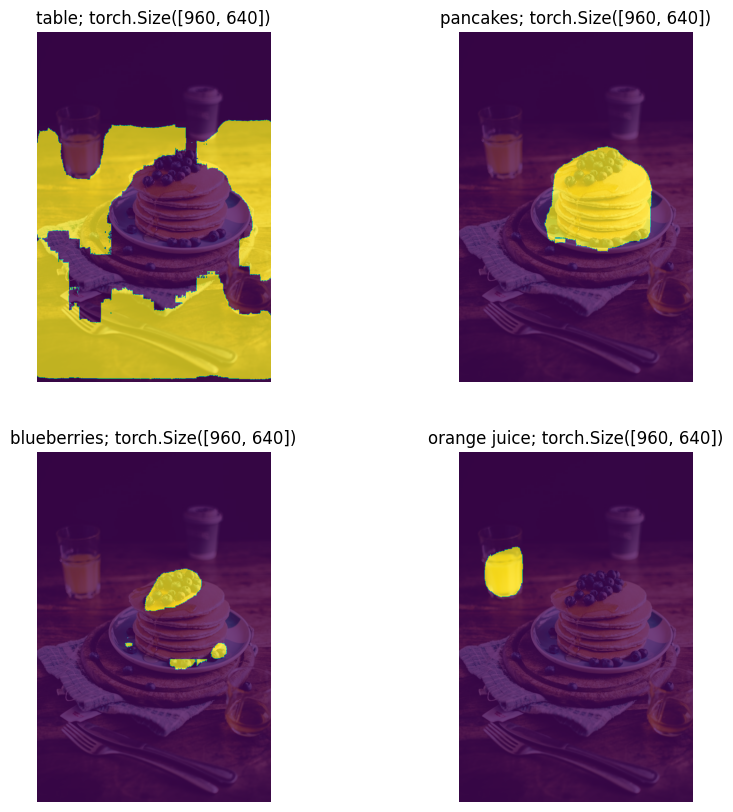

In [45]:
import matplotlib.pyplot as plt

thresh = 0.5

# Show plots in 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
  ax.imshow(image)
  ax.imshow(preds[i].cpu().numpy() > thresh, cmap="viridis", alpha=0.75)
  ax.axis("off")
  ax.set_title(f"{prompts[i]}; {preds[i].shape}")